In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import seaborn as sns
import numpy as np
from tqdm import tqdm
np.random.seed(0)

# Classification in a 2-dimensional space

The file `fisherData.mat` contains two data matrices, `data1` and `data2`, whose rows contain hypothetical normalized responses of 2 mouse auditory neurons to different stimuli – The first matrix contains responses to dogs barking, and the second are responses to cat vocalizations. You would like to know whether the responses of these two neurons could be used by the mouse to differentate the two types of sound. We’ll implement three classifiers.

In [2]:
data = loadmat('fisherData.mat')
index = pd.Series(np.arange(len(data['data1'])), name='trial')
columns = pd.Series([0, 1], name='neuron')
dog = pd.DataFrame(data['data1'], columns=columns, index=index)
cat = pd.DataFrame(data['data2'], columns=columns, index=index)

# a)

The prototype classifier assigns to observations the label of the class of training samples whose mean is closest to the observation. To be precise, given an example $x$, the classifier assigns it a class $\hat y$ according to the rule 

$\hat y = \begin{cases}
    A & \text{if $\hat w^Tx > 0$} \\
    B & \text{otherwise}
\end{cases}$ where the discriminant vector $\hat w$ is $\frac{\mu_A - \mu_B}{\lVert \mu_A - \mu_B \rVert}$.

The origin of our coordinate system is taken to be exactly between the means of each class (we achieve this by subtracting $\frac{1}{2}(\mu_A + \mu_B)$ from $x$ as a preprocessing step).

Assume that samples of class $A$ are drawn from $\mathcal{N}(\mu_A, I)$ and samples of class $B$ are drawn from $\mathcal{N}(\mu_B, I)$. Then classes $A$ and $B$ have likelihood functions

$p(x|y=A) = \frac{1}{\sqrt{(2\pi)^N \lvert I \rvert}} e^{-\frac{1}{2}(x - \mu_A)^T I (x - \mu_A)} = \frac{1}{\sqrt{(2\pi)^N}} e^{-\frac{1}{2}(x - \mu_A)^T (x - \mu_A)}$ and

$p(x|y=B) = \frac{1}{\sqrt{(2\pi)^N}} e^{-\frac{1}{2}(x - \mu_B)^T (x - \mu_B)}$.

A maximum likelihood classifier assigns to observations the label of the class whose likelihood function is maximized by the observation. It assigns an example $x$ to class $\hat y$ according to the rule

$\hat y = \begin{cases}
    A & \text{if $p(x|y=A) > p(x|y=B)$} \\
    B & \text{otherwise}
\end{cases} = \begin{cases}
    A & \text{if $\frac{p(x|y=A)}{p(x|y=B)} > 1$} \\
    B & \text{otherwise}
\end{cases} = \begin{cases}
    A & \text{if $\ln[\frac{p(x|y=A)}{p(x|y=B)}] > 0$} \\
    B & \text{otherwise}
\end{cases}$

We must show that the two different decision rules stated above are equivalent. Consider the quantity $\ln\frac{p(x|y=A)}{p(x|y=B)}$. We may rewrite it as

$\ln[\frac{\frac{1}{\sqrt{(2\pi)^N}} e^{-\frac{1}{2}(x - \mu_A)^T (x - \mu_A)}}{\frac{1}{\sqrt{(2\pi)^N}} e^{-\frac{1}{2}(x - \mu_B)^T (x - \mu_B)}}]
= \ln[\frac{e^{-\frac{1}{2}(x - \mu_A)^T (x - \mu_A)}}{e^{-\frac{1}{2}(x - \mu_B)^T (x - \mu_B)}}]
= -\frac{1}{2}(x - \mu_A)^T (x - \mu_A) + \frac{1}{2}(x - \mu_B)^T (x - \mu_B)$

$= -\frac{1}{2}x^Tx + \frac{1}{2}x^T\mu_A + \frac{1}{2}\mu_A^Tx - \frac{1}{2}\mu_A^T\mu_A + \frac{1}{2}x^Tx - \frac{1}{2}x^T\mu_B - \frac{1}{2}\mu_A^Tx + \frac{1}{2}\mu_B^T\mu_B$

$= x^T\mu_A - x^T\mu_B - \frac{1}{2}(\mu_A^T\mu_A - \mu_B^T\mu_B)$

$= x^T(\mu_A - \mu_B) - \frac{1}{2}(\mu_A^T\mu_A - \mu_B^T\mu_B)$.

We may then write the inequality in our decision rule as $x^T(\mu_A - \mu_B) > \frac{1}{2}(\mu_A^T\mu_A - \mu_B^T\mu_B)$ or

$w^Tx > b$, where $w = \mu_A - \mu_B$ and $b = \frac{1}{2}\mu_A^T\mu_A - \frac{1}{2}\mu_B^T\mu_B$.

Since the origin of our coordinate system is equidistant from $\mu_A$ and $\mu_B$, $\mu_A^T\mu_A = \mu_B^T\mu_B$ and $b = 0$. Let $\hat w$ be the unit vector $\frac{w}{\lVert w \rVert}$. Our inequality becomes

$\hat w^Tx > 0$.

We may then write the ML decision rule as

$\hat y = \begin{cases}
    A & \text{if $\hat w^Tx > 0$} \\
    B & \text{otherwise}
\end{cases}$ where $\hat w$ = $\frac{\mu_A - \mu_B}{\lVert \mu_A - \mu_B \rVert}$.

This coincides with the decision rule for the prototype classifier. Therefore, the prototype classifier is the maximum likelihood classifier under the assumptions made above.

In [3]:
xx = np.linspace(-6, 7, 500)
yy = np.linspace(-1, 2.7, 500)
XX, YY = np.meshgrid(xx, yy)
D = np.stack([XX.flatten(), YY.flatten()]).T

In [4]:
mu1 = dog.mean(axis=0).values
mu2 = cat.mean(axis=0).values
pdf1 = np.exp(-0.5 * np.sum((D - mu1) ** 2, axis=1))
pdf2 = np.exp(-0.5 * np.sum((D - mu2) ** 2, axis=1))
mask = pdf1 > pdf2
im = mask.reshape(len(xx), len(yy))

We may visualize the solution by generating a binary image showing the classification output, with the data points scatterplotted on top.

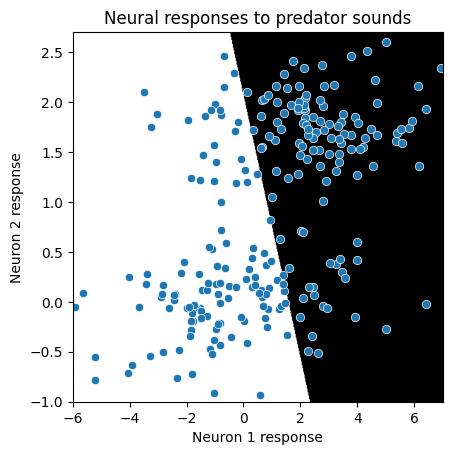

In [5]:
plt.subplots()
plt.title('Neural responses to predator sounds')
plt.imshow(np.flipud(im), extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap='gray')
sns.scatterplot(pd.concat([dog, cat]), x=0, y=1)
plt.xlabel('Neuron 1 response')
plt.ylabel('Neuron 2 response')
plt.gca().set_aspect((xx.max() - xx.min())/(yy.max() - yy.min()))

Compute the weight vector, and plot it with the decision boundary.

In [6]:
center = (mu1 + mu2) / 2
w = mu2 - mu1
w /= np.sqrt(w @ w)

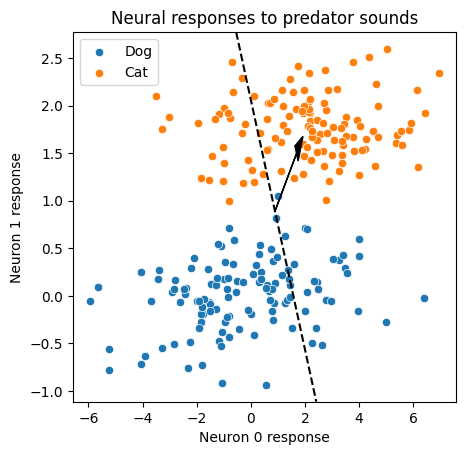

In [7]:
plt.subplots()
plt.title('Neural responses to predator sounds')
sns.scatterplot(dog, x=0, y=1, label='Dog')
sns.scatterplot(cat, x=0, y=1, label='Cat')
plt.gca().arrow(*center, *w, head_width=0.2, color='k')
plt.axline(center, slope=-w[0]/w[1], color="black", linestyle='--')
plt.xlabel('Neuron 0 response')
plt.ylabel('Neuron 1 response')
plt.gca().set_aspect(13/3.7)

What fraction of points are correctly classified?

In [8]:
X = pd.concat([dog, cat]) - center
y = np.concatenate([-np.ones(len(dog)), np.ones(len(cat))])
frac = np.sum(np.sign(X @ w) == y) / X.shape[0]
print(f"Fraction correct: {frac:0.3f}")

Fraction correct: 0.783


We can plot the distributions of projection along the discriminant vector for each class.

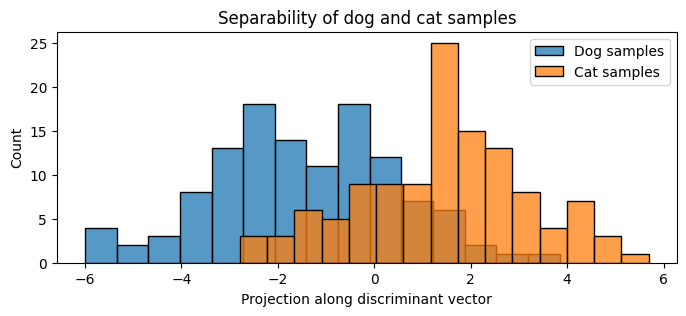

In [9]:
dog_proj = (dog - center) @ w
cat_proj = (cat - center) @ w
plt.subplots(figsize=(8, 3))
sns.histplot(dog_proj, label='Dog samples', bins=15)
sns.histplot(cat_proj, label='Cat samples', bins=15)
plt.title('Separability of dog and cat samples')
plt.xlabel('Projection along discriminant vector')
plt.ylabel('Count')
plt.legend()
plt.show()

The two distributions are not very well separated. Consider a decision line bisecting their overlap (near x=0 in the histogram above). "Dog" samples to the right of this line and "cat" samples to the left of this line will be misclassified.

# b)

Here we follow the same proof format as in part (a), but with the inverse covariance matrix $C^{-1}$ factoring into most calculations.

Fisher's linear discriminant assigns to observations the class label which maximizes the average squared between-class mean distance, while minimizing the sum of within-class squared distances. It assigns an example $x$ to a class $\hat y$ according to the rule 

$\hat y = \begin{cases}
    A & \text{if $\hat w^Tx > 0$} \\
    B & \text{otherwise}
\end{cases}$ where the discriminant vector $\hat w$ is $C^{-1}(\frac{\mu_A}{\lVert \mu_A \rVert} - \frac{\mu_B}{\lVert \mu_B \rVert})$. C is the average of class covariance matrices $\frac{1}{2}(C_A + C_B)$.

Again, we set the origin of our coordinate system to be exactly between the means of each class by subtracting $\frac{1}{2}(\mu_A + \mu_B)$ from $x$ in preprocessing.

Assume that samples of class $A$ are drawn from $\mathcal{N}(\mu_A, C)$ and samples of class $B$ are drawn from $\mathcal{N}(\mu_B, C)$, for some shared covariance matrix C. Then classes $A$ and $B$ have likelihood functions

$p(x|y=A) = \frac{1}{\sqrt{(2\pi)^N \lvert C \rvert}} e^{-\frac{1}{2}(x - \mu_A)^T C^{-1} (x - \mu_A)}$

$p(x|y=B) = \frac{1}{\sqrt{(2\pi)^N \lvert C \rvert}} e^{-\frac{1}{2}(x - \mu_B)^T C^{-1} (x - \mu_B)}$.

A maximum likelihood classifier assigns an example $x$ to class $\hat y$ according to the rule

$\hat y = \begin{cases}
    A & \text{if $\ln[\frac{p(x|y=A)}{p(x|y=B)}] > 0$} \\
    B & \text{otherwise}
\end{cases}$

Again we must show that the two different decision rules above are equivalent. We may rewrite the quantity $\ln\frac{p(x|y=A)}{p(x|y=B)}$ as

$\ln[\frac{\frac{1}{\sqrt{(2\pi)^N\lvert C \rvert}} e^{-\frac{1}{2}(x - \mu_A)^T C^{-1} (x - \mu_A)}}{\frac{1}{\sqrt{(2\pi)^N\lvert C \rvert}} e^{-\frac{1}{2}(x - \mu_B)^T C^{-1} (x - \mu_B)}}]
= \ln[\frac{e^{-\frac{1}{2}(x - \mu_A)^T C^{-1} (x - \mu_A)}}{e^{-\frac{1}{2}(x - \mu_B)^T C^{-1} (x - \mu_B)}}]
= -\frac{1}{2}(x - \mu_A)^T C^{-1} (x - \mu_A) + \frac{1}{2}(x - \mu_B)^T C^{-1} (x - \mu_B)$

$= -\frac{1}{2}x^T C^{-1} x + \frac{1}{2}x^T C^{-1} \mu_A + \frac{1}{2}\mu_A^T C^{-1} x - \frac{1}{2}\mu_A^T C^{-1} \mu_A + \frac{1}{2}x^T C^{-1} x - \frac{1}{2}x^T C^{-1} \mu_B - \frac{1}{2}\mu_A^T C^{-1} x + \frac{1}{2}\mu_B^T C^{-1} \mu_B$

$= x^T C^{-1} \mu_A - x^T C^{-1} \mu_B - \frac{1}{2}(\mu_A^T C^{-1} \mu_A - \mu_B^T C^{-1} \mu_B)$

$= x^T C^{-1} (\mu_A - \mu_B) - \frac{1}{2}(\mu_A^T C^{-1} \mu_A - \mu_B^T C^{-1} \mu_B)$.

We may then write the inequality in our decision rule as $x^T C^{-1} (\mu_A - \mu_B) > \frac{1}{2}(\mu_A^T C^{-1} \mu_A - \mu_B^T C^{-1} \mu_B)$ or

$w^Tx > b$, where $w =  C^{-1} (\mu_A - \mu_B)$ and $b = \frac{1}{2}\mu_A^T C^{-1} \mu_A - \frac{1}{2}\mu_B^T C^{-1} \mu_B$.

Since the origin of our coordinate system is equidistant from $\mu_A$ and $\mu_B$, $\mu_A^T C^{-1} \mu_A = \mu_B^T C^{-1} \mu_B$ and $b = 0$. We may rescale $w$ to the unit vector $\hat w$ by replacing $\mu_A$ and $\mu_B$ in its equation with unit vectors $\frac{\mu_A}{\lVert \mu_A \rVert}$ and $\frac{\mu_B}{\lVert \mu_B \rVert}$.

Then our inequality becomes

$\hat w^Tx > 0$ where $\hat w = C^{-1}(\frac{\mu_A}{\lVert \mu_A \rVert} - \frac{\mu_B}{\lVert \mu_B \rVert})$.

We may then write the ML decision rule as

$\hat y = \begin{cases}
    A & \text{if $\hat w^Tx > 0$} \\
    B & \text{otherwise}
\end{cases}$.

This coincides with the decision rule for Fisher's linear discriminant. Therefore, it is a maximum likelihood classifier under the assumptions made above.

In [10]:
def cov(data):
    var = data - data.mean(axis=0)
    n = len(var) - 1
    return var.T @ var / n

Below we estimate the common covariance for the cat and dog datasets:

In [11]:
C = (cov(cat) + cov(dog)) / 2
display(C)

neuron,0,1
neuron,,
0,4.972170,0.159544
1,0.159544,0.125787


Now we repeat the plotting exercises in part (a).

In [12]:
def inv(X):
    U, s, Vt = np.linalg.svd(X)
    return Vt.T @ np.diag(1 / s) @ U

In [13]:
C_inv = inv(C)
for i, d in enumerate(D):
    pdf1[i] = np.exp(-0.5 * ((d - mu1).T @ C_inv @ (d - mu1)))
    pdf2[i] = np.exp(-0.5 * ((d - mu2).T @ C_inv @ (d - mu2)))
pdf1 /= np.sum(pdf1)
pdf2 /= np.sum(pdf2)
    
mask = pdf1 > pdf2
im = mask.reshape(len(xx), len(yy))

We show classification output as a binary image with data points scattered on top, and we plot the data with weight vector and decision boundary.

In [14]:
def unit(vec):
    return vec / np.sqrt(vec @ vec)

In [15]:
w = C_inv @ (unit(mu2) - unit(mu1))
w /= np.sqrt(w @ w)

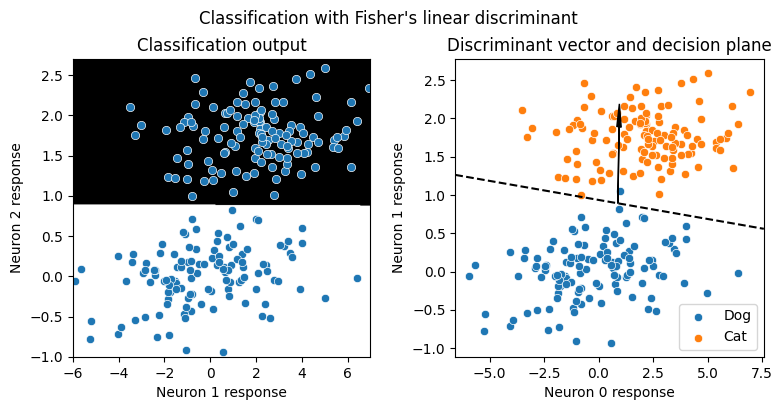

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle("Classification with Fisher's linear discriminant")

plt.sca(axs[0])
plt.imshow(np.flipud(im), extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap='gray')
sns.scatterplot(pd.concat([dog, cat]), x=0, y=1)
plt.title('Classification output')
plt.xlabel('Neuron 1 response')
plt.ylabel('Neuron 2 response')
plt.gca().set_aspect((xx.max() - xx.min())/(yy.max() - yy.min()))

plt.sca(axs[1])
sns.scatterplot(dog, x=0, y=1, label='Dog')
sns.scatterplot(cat, x=0, y=1, label='Cat')
plt.gca().arrow(*center, *w, head_width=0.2, color='k')
plt.axline(center, slope=-w[0]/w[1], color="black", linestyle='--')
plt.title('Discriminant vector and decision plane')
plt.xlabel('Neuron 0 response')
plt.ylabel('Neuron 1 response')
plt.gca().set_aspect((xx.max() - xx.min())/(yy.max() - yy.min()))

plt.tight_layout()
plt.show()

What fraction of points are correctly classified?

In [17]:
frac = np.sum(np.sign(X @ w) == y) / X.shape[0]
print(f"Fraction correct: {frac:0.3f}")

Fraction correct: 0.996


We now plot the distributions of projection along the discriminant vector for each class.

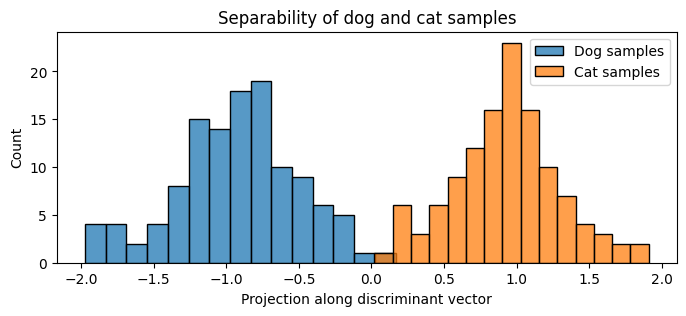

In [18]:
dog_proj = (dog - center) @ w
cat_proj = (cat - center) @ w
plt.subplots(figsize=(8, 3))
sns.histplot(dog_proj, label='Dog samples', bins=15)
sns.histplot(cat_proj, label='Cat samples', bins=15)
plt.title('Separability of dog and cat samples')
plt.xlabel('Projection along discriminant vector')
plt.ylabel('Count')
plt.legend()
plt.show()

The two distributions are quite well separated.

# c)

Now we compute the ridge-regularized Fisher's discriminant by estimating the covariance matrix as $\Sigma_{Estimated} = (1 - \lambda)\Sigma_{Data} + \lambda I$, where $\Sigma_{Data}$ is the sample covariance matrix from part (b). We run 100 repeats of cross-validation with a 95:5 train-test split for $\lambda$ from 0 to 1 in increments of 0.05.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
lambdas = np.arange(0, 1 + 1e-10, 0.05)
score_avg = np.zeros_like(lambdas)
score_std = np.zeros_like(lambdas)
for i, lambd in enumerate(lambdas):
    fracs = np.zeros(100)
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
        
        X_dog = X_train[y_train == -1]
        X_cat = X_train[y_train == 1]
        C = (cov(X_dog) + cov(X_cat)) / 2
        
        C_est = (1 - lambd) * C + lambd * np.identity(C.shape[0])
        w = inv(C_est) @ (unit(mu2) - unit(mu1))
        w /= np.sqrt(w @ w)
    
        fracs[j] = np.sum(np.sign(X_test @ w) == y_test) / X_test.shape[0]        
    score_avg[i] = np.mean(fracs)
    score_std[i] = np.std(fracs)

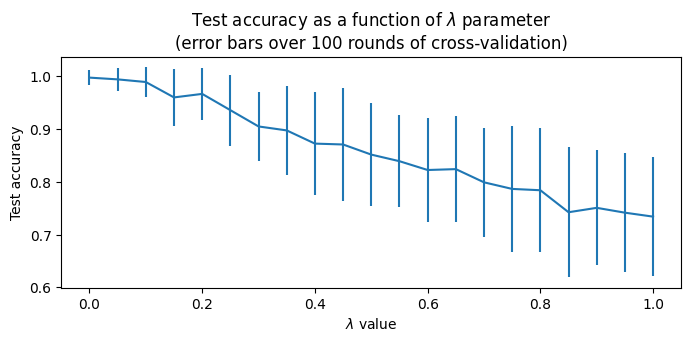

In [24]:
plt.subplots(figsize=(8, 3))
plt.errorbar(x=lambdas, y=score_avg, yerr=score_std)
plt.title("Test accuracy as a function of $\lambda$ parameter\n(error bars over 100 rounds of cross-validation)")
plt.xlabel('$\lambda$ value')
plt.ylabel('Test accuracy')
plt.show()

I think $\lambda = 0.0$ (Fisher's discriminant) is the best value for $\lambda$, since it has the highest test accuracy and the lowest standard deviation across repeat cross-validation runs.

# d)

Finally we consider the quadratic classifier. First we estimate the mean and covariance of data measured for each condition.

In [71]:
C_dog = cov(dog)
C_dog = cov(cat)
print("Covariance matrix for dog class:")
display(C_dog)
print("Covariance matrix for cat class:")
display(C_cat)

Covariance matrix for dog class:


neuron,0,1
neuron,,
0,4.725933,0.067809
1,0.067809,0.113292


Covariance matrix for cat class:


neuron,0,1
neuron,,
0,4.725933,0.067809
1,0.067809,0.113292


The quadratic classifier for this problem assigns an example $x$ to class $\hat y$ according to the rule

$\hat y = \begin{cases}
    dog & \text{if $\ln[\frac{p(x|y=dog)}{p(x|y=cat)}] > 0$} \\
    cat & \text{otherwise}
\end{cases}$

$p(x|y=dog)$ and $p(x|y=cat)$ are Gaussian with PDFs

$p(x|y=dog) = (2\pi)^{-\frac{N}{2}} \lvert C_{dog} \rvert^{-\frac{1}{2}} e^{-\frac{1}{2}(x - \mu_{dog})^T C_{dog}^{-1} (x - \mu_{dog})}$

$p(x|y=cat) = (2\pi)^{-\frac{N}{2}} \lvert C_{cat} \rvert^{-\frac{1}{2}} e^{-\frac{1}{2}(x - \mu_{cat})^T C_{cat}^{-1} (x - \mu_{cat})}$.

We may rewrite the quantity $\ln\frac{p(x|y=dog)}{p(x|y=cat)}$ as

$\ln[\frac{\lvert C_{dog} \rvert^{-\frac{1}{2}} e^{-\frac{1}{2}(x - \mu_{dog})^T C_{dog}^{-1} (x - \mu_{dog})}}{\lvert C_{cat} \rvert^{-\frac{1}{2}} e^{-\frac{1}{2}(x - \mu_{cat})^T C_{cat}^{-1} (x - \mu_{cat})}}]$

$= -\frac{1}{2}\lvert C_{dog} \rvert - \frac{1}{2}(x - \mu_{dog})^T C_{dog}^{-1} (x - \mu_{dog}) + \frac{1}{2}\lvert C_{cat} \rvert + \frac{1}{2}(x - \mu_{cat})^T C_{cat}^{-1} (x - \mu_{cat})
$.

This means we can write our decision rule as

$\hat y = \begin{cases}
    dog & \text{if $-\frac{1}{2}\lvert C_{dog} \rvert - \frac{1}{2}(x - \mu_{dog})^T C_{dog}^{-1} (x - \mu_{dog}) + \frac{1}{2}\lvert C_{cat} \rvert + \frac{1}{2}(x - \mu_{cat})^T C_{cat}^{-1} (x - \mu_{cat}) > 0$} \\
    cat & \text{otherwise}.
\end{cases}$

In [77]:
def det(C):
    return C[0, 0] * C[1, 1] - C[0, 1] * C[1, 0]

In [122]:
C_dog_inv = inv(C_dog.values)
C_cat_inv = inv(C_cat.values)
mu_dog = mu1
mu_cat = mu2
const = -0.5 * det(C_dog.values) + 0.5 * det(C_cat.values)

def classify(x):
    dog_term = -0.5 * (x - mu_dog).T @ C_dog_inv @ (x - mu_dog)
    cat_term = 0.5 * (x - mu_cat).T @ C_cat_inv @ (x - mu_cat)
    lpr = const + dog_term + cat_term
    return -1 if lpr > 0 else 1

We show classification output as a binary image with data points scattered on top and colored by class.

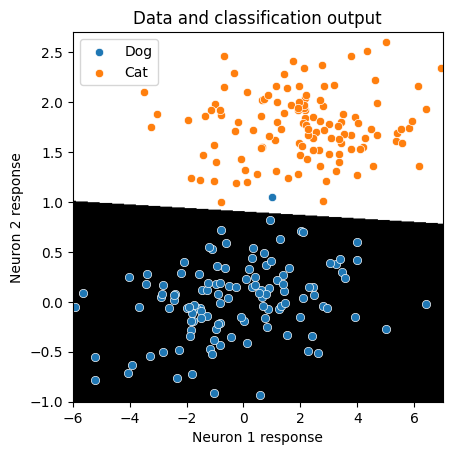

In [118]:
for i, d in enumerate(D):
    mask[i] = 0 if classify(d) == -1 else 1
im = mask.reshape(len(xx), len(yy))

plt.subplots()
plt.title("Quadratic classification of cats and dogs")
plt.imshow(np.flipud(im), extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap='gray')
sns.scatterplot(dog, x=0, y=1, label='Dog')
sns.scatterplot(cat, x=0, y=1, label='Cat')
plt.title('Data and classification output')
plt.xlabel('Neuron 1 response')
plt.ylabel('Neuron 2 response')
plt.gca().set_aspect((xx.max() - xx.min())/(yy.max() - yy.min()))
plt.show()

We compute the fraction correct.

In [127]:
X = pd.concat([dog, cat]).values
y_pred = [classify(x) for x in X]
frac = np.sum(y_pred == y) / X.shape[0]
print(f"Fraction correct: {frac:0.3f}")

Fraction correct: 0.996


QDA, unregularized LDA, and regularized LDA have the same fraction correct in my experiments. They outrank the prototype classifier.

Between unregularized LDA and regularized LDA, I **prefer regularized LDA**. This is because both unregularized LDA and the prototype classifier are special cases of regularized LDA, and will be selected by cross-validation if either of them are in fact better.

Between regularized LDA and QDA, I would **prefer QDA in most cases** as it is parameter-free model and so doesn't require a cross-validation step.

Still, there are situations I might prefer an inferior classifier. Like QDA, unregularized LDA and prototype classifiers don't require cross-validation. With too few data, the cross-validation in regularized LDA could result in overfitting, or selecting a model that doesn't generalize well to new examples.

I might also use a prototype or LDA classifier if I have certain prior beliefs about how the dimensions in my dataset relate to one another semantically. If all dimensions are isotropic in their units (as in the case of pixel data or readings from a bank of identical sensors), I may choose a prototype classifier. If I expect (or measure) that the classes in my data have identical covariance, this may bias me toward unregularized LDA.